In [1]:
#initialize dependencies, h2o as primary
import datetime  # for timestamp
import h2o  # base h2o package for python
from h2o.estimators.glm import H2OGeneralizedLinearEstimator  # h2o elastic net models class
from h2o.grid.grid_search import H2OGridSearch  # grid search class and syntax for h2o models
from interpret import show  # basic visualizations from interpret package
from interpret.glassbox import ExplainableBoostingClassifier  # interpret ebm class
from interpret.perf import ROC  # ROC measure for ebm
import itertools  # for cartesian product of parameters
import matplotlib.pyplot as plt  # basic plotting
import numpy as np  # for basic array manipulation
import pandas as pd  # for dataframe manipulation
import seaborn as sns  # slightly better plotting
import time  # for timers
import xgboost as xgb  # base xgboost package for python

# set numpy random seed for better reproducibility
SEED = 12345

# set number of threads
NTHREAD = 4

h2o.init(max_mem_size='6G',
         nthreads=NTHREAD)  # start h2o with plenty of memory and threads
h2o.remove_all()  # clears h2o memory
h2o.no_progress()  # turn off h2o progress indicators

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; OpenJDK 64-Bit Server VM Zulu11.37+18-SA (build 11.0.6+10-LTS, mixed mode)
  Starting server from C:\Users\zvila\anaconda3\lib\site-packages\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\zvila\AppData\Local\Temp\tmpt5fniewm
  JVM stdout: C:\Users\zvila\AppData\Local\Temp\tmpt5fniewm\h2o_zvila_started_from_python.out
  JVM stderr: C:\Users\zvila\AppData\Local\Temp\tmpt5fniewm\h2o_zvila_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,America/New_York
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.32.1.3
H2O_cluster_version_age:,16 days
H2O_cluster_name:,H2O_from_python_zvila_0lk6j4
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,6 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"accepting new members, healthy"


In [2]:
#import data (test data will not be used for model fitting)
data = pd.read_csv('hmda_train_preprocessed.csv')
test = pd.read_csv('hmda_test_preprocessed.csv')

# Feature Assignment (Parametric Model)

In [3]:
#assign x and y features
y_name = 'high_priced'
x_names = [
    'term_360', 'conforming', 'debt_to_income_ratio_missing',
    'loan_amount_std', 'loan_to_value_ratio_std', 'no_intro_rate_period_std',
    'intro_rate_period_std', 'property_value_std', 'income_std',
    'debt_to_income_ratio_std'
]

## Boxplots of Features

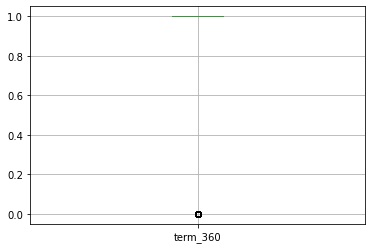

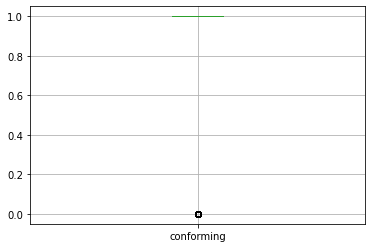

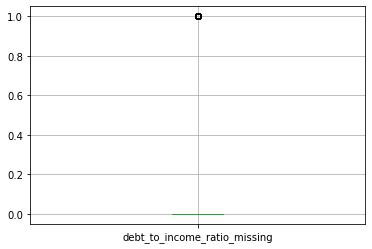

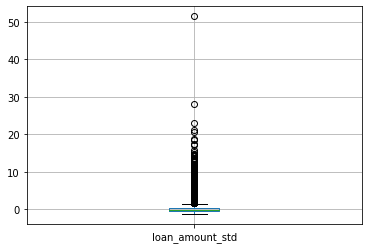

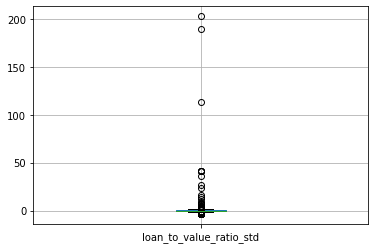

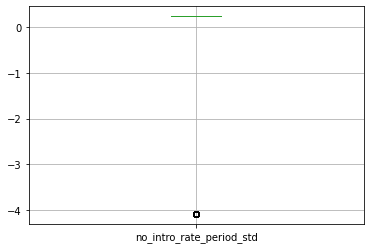

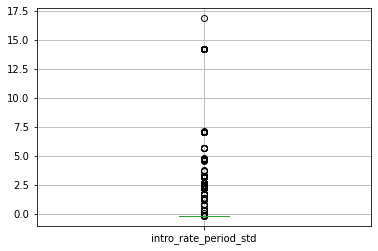

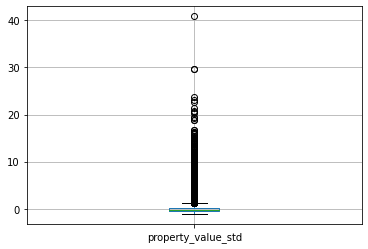

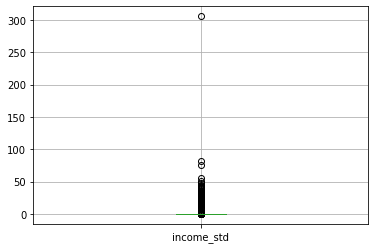

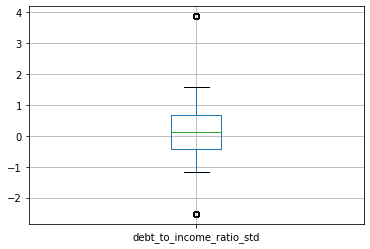

In [4]:
#data exploration with boxplots
for i in data[x_names]:
    data[x_names].boxplot(column=i)
    plt.show()

# Correlation of Features & Predictor (High-Priced)

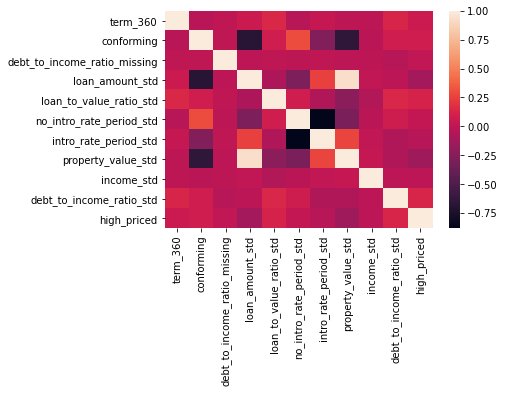

In [5]:
#correlation analysis
corr = data[x_names + [y_name]].corr()
_ = sns.heatmap(corr,
                xticklabels=corr.columns.values,
                yticklabels=corr.columns.values)

# Data Partitioning: Training & Validation Sets

In [6]:
#partition data
np.random.seed(SEED)  # preserve reproducibility

split_ratio = 0.70  # 70%/30% train/test split

# execute split
split = np.random.rand(len(data)) < split_ratio
train = data[split]
valid = data[~split]

# summarize split
print('Training data = %d, columns = %d' % (train.shape[0], train.shape[1]))
print('Validation data = %d, columns = %d' % (valid.shape[0], valid.shape[1]))

Training data = 112253, columns = 23
Validation data = 48085, columns = 23


# Explainable Boosting Machine Model

In [7]:
#Define function for random grid search
def ebm_grid(train,
             valid,
             x_names,
             y_name,
             gs_params=None,
             n_models=None,
             early_stopping_rounds=None,
             seed=None):
    """ Performs a random grid search over n_models and gs_params.

    :param train: Training data as Pandas DataFrame.
    :param valid: Validation data as Pandas DataFrame.
    :param x_names: Names of input features.
    :param y_name: Name of target feature.
    :param gs_params: Dictionary of lists of potential EBM parameters over which to search.   
    :param n_models: Number of random models to evaluate.
    :param early_stopping_rounds: EBM early stopping rounds.
    :param seed: Random seed for better interpretability.
    :return: Best candidate model from random grid search.

    """

    # cartesian product of gs_params
    keys, values = zip(*gs_params.items())
    experiments = [dict(zip(keys, v)) for v in itertools.product(*values)]

    # preserve exact reproducibility for this function
    np.random.seed(SEED)

    # select randomly from cartesian product space
    selected_experiments = np.random.choice(len(experiments), n_models)

    # set global params for seed, etc.
    params = {
        'n_jobs': NTHREAD,
        'early_stopping_rounds': early_stopping_rounds,
        'random_state': SEED
    }

    # init grid search loop
    best_candidate = None
    best_score = 0

    # grid search loop
    for i, exp in enumerate(selected_experiments):

        params.update(experiments[exp]
                      )  # override global params with current grid run params

        print('Grid search run %d/%d:' % (int(i + 1), int(n_models)))
        print('Training with parameters:', params)

        # train
        ebm = ExplainableBoostingClassifier(**params)
        candidate = ebm.fit(train[x_names], train[y_name])

        # calculate AUC
        ebm_perf = ROC(ebm.predict_proba).explain_perf(valid[x_names],
                                                       valid[y_name])
        candidate_best_score = ebm_perf._internal_obj['overall']['auc']

        # determine if current model is better than previous best
        if candidate_best_score > best_score:
            best_candidate = candidate
            best_score = candidate_best_score
            print(
                'Grid search new best score discovered at iteration %d/%d: %.4f.'
                % (int(i + 1), int(n_models), candidate_best_score))

        print('---------- ----------')

        del ebm

    return best_candidate

## Random Grid Search: EBM Model Fit (20 iterations)

Utilize Early Stopping to minimize overfitting

In [8]:
# dictionary of hyperparameter value lists for grid search
gs_params = {
    'max_bins': [128, 256, 512],
    'max_interaction_bins': [16, 32, 64],
    'interactions': [10, 15, 20],
    'outer_bags': [6, 10, 14],
    'inner_bags': [0, 4, 8],
    'learning_rate': [0.005, 0.001, 0.01],
    'validation_size': [0.2, 0.4, 0.5],
    'min_samples_leaf': [1, 2, 5, 10],
    'max_leaves': [3, 5, 7] 
}

# EBM grid search, use early stopping
best_ebm = ebm_grid(train,
                    valid,
                    x_names,
                    y_name,
                    gs_params=gs_params,
                    n_models=20,
                    early_stopping_rounds=100,
                    seed=SEED)

Grid search run 1/20:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 512, 'max_interaction_bins': 32, 'interactions': 10, 'outer_bags': 10, 'inner_bags': 8, 'learning_rate': 0.005, 'validation_size': 0.2, 'min_samples_leaf': 10, 'max_leaves': 5}
Grid search new best score discovered at iteration 1/20: 0.8230.
---------- ----------
Grid search run 2/20:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 256, 'max_interaction_bins': 32, 'interactions': 10, 'outer_bags': 6, 'inner_bags': 0, 'learning_rate': 0.01, 'validation_size': 0.4, 'min_samples_leaf': 1, 'max_leaves': 5}
---------- ----------
Grid search run 3/20:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 128, 'max_interaction_bins': 16, 'interactions': 20, 'outer_bags': 6, 'inner_bags': 8, 'learning_rate': 0.005, 'validation_size': 0.4, 'min_samples_leaf': 2, '

### Model Assessment: AUC of Best Model

In [9]:
best_ebm_perf = ROC(best_ebm.predict_proba).explain_perf(
    valid[x_names], valid[y_name])
print('Validation AUC: %.5f.' % best_ebm_perf._internal_obj['overall']['auc'])

Validation AUC: 0.82480.


In [10]:
#create submission file
best_ebm_submit = pd.DataFrame(best_ebm.predict_proba(test[x_names])[:, 1],
                               columns=['phat'])
best_ebm_submit.to_csv(
    'ph_best_ebm_' +
    str(datetime.datetime.now().strftime("%Y_%m_%d_%H_%M_%S") + '.csv'),
    index=False)

### Evaluate Validation data

In [11]:
#validation data scoring
best_ebm_phat = pd.DataFrame(best_ebm.predict_proba(valid[x_names])[:, 1],
                             columns=['phat'])
best_ebm_phat = pd.concat([valid.reset_index(drop=True), best_ebm_phat],
                          axis=1)
best_ebm_phat.head()

,row_id,black,asian,white,amind,hipac,hispanic,non_hispanic,male,female,...,debt_to_income_ratio_missing,loan_amount_std,loan_to_value_ratio_std,no_intro_rate_period_std,intro_rate_period_std,property_value_std,income_std,debt_to_income_ratio_std,high_priced,phat
0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,...,0,-0.514393,0.333922,0.244394,-0.215304,-0.535932,-0.040307,0.854601,0,0.176244
1,6,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0,-0.426448,0.355249,0.244394,-0.215304,-0.474263,-0.020904,1.037419,0,0.313167
2,8,0.0,0.0,1.0,0.0,0.0,0.0,1.0,NaN,NaN,...,0,0.277109,0.142995,0.244394,-0.215304,0.111598,-0.019865,0.031916,0,0.022014
3,10,0.0,0.0,1.0,0.0,0.0,0.0,1.0,NaN,NaN,...,0,-0.382476,-0.240432,0.244394,-0.215304,-0.320089,-0.028181,0.946010,0,0.016899
4,11,0.0,0.0,1.0,0.0,0.0,1.0,0.0,NaN,NaN,...,0,0.101220,-0.266529,0.244394,-0.215304,0.111598,0.016515,-1.156406,0,0.004372


In [13]:
#utility function for selecting percentiles
def get_percentile_dict(yhat_name, frame, id_):

    """ Returns the percentiles of a column, yhat_name, as the indices based on
        another column id_.
        :param yhat_name: Name of column in frame in which to find percentiles.
        :param frame: Pandas frame.
        :param id_: Validation Pandas frame containing yhat and id_.
        :return: Dictionary of percentile values and index column values.
    """

    # create a copy of frame and sort it by yhat
    sort_df = frame.copy(deep=True)
    sort_df.sort_values(yhat_name, inplace=True)
    sort_df.reset_index(inplace=True)

    # find top and bottom percentiles
    percentiles_dict = {0: sort_df.loc[0, id_], 99: sort_df.loc[sort_df.shape[0] - 1, id_]}

    # find 10th-90th percentiles
    inc = sort_df.shape[0] // 10
    for i in range(1, 10):
        percentiles_dict[i * 10] = sort_df.loc[i * inc, id_]

    return percentiles_dict

In [14]:
#select percentiles from predictions
best_ebm_percentiles = get_percentile_dict('phat', best_ebm_phat, 'row_id')
for key in sorted(best_ebm_percentiles.keys()):
    print(str(key) + ': ' + str(best_ebm_percentiles[key]))

0: 144277
10: 46654
20: 6091
30: 79246
40: 113428
50: 10748
60: 18463
70: 150299
80: 7468
90: 37670
99: 33940


### EBM Contributions

In [16]:
#calculate EBM contributions

# use EBM feature scores as local importance
# use mean abs score as global importance
best_ebm_contribs = best_ebm.explain_local(valid[x_names])
names = best_ebm_contribs._internal_obj['specific'][0]['names']
best_ebm_contribs_df = pd.DataFrame(columns=names)

# extract scores from insane _internal_obj
# new versions just have predict_and_explain() function
# use that if you can
for i in range(0, valid.shape[0]):
    row_df = pd.DataFrame(np.array(
        best_ebm_contribs._internal_obj['specific'][i]['scores']).reshape(
            1, 30),
                          columns=names)
    best_ebm_contribs_df = best_ebm_contribs_df.append(row_df,
                                                       ignore_index=True)
    del row_df

In [56]:
# use coefficients as relative global feature importance
global_fi = pd.DataFrame()

#assign variable
global_fi['EBM Importance'] = np.abs(best_ebm_contribs_df).mean()

NameError: name 'sort' is not defined

### Compile local feature importance

In [49]:
valid_idx_map = valid['row_id'].copy(deep=True)
valid_idx_map.reset_index(drop=True, inplace=True)

# init frame to store local contribs
local_fi_dict = {10: pd.DataFrame(columns = ['EBM Contribution'], index=x_names),
                 50: pd.DataFrame(columns = ['EBM Contribution'], index=x_names),
                 90: pd.DataFrame(columns = ['EBM Contribution'], index=x_names)}

# extract scores at three percentiles of phat
for percentile in [10, 50, 90]:

    # using valid_idx_map and percentiles dict
    # to find the right local contributions
    idx = valid_idx_map[valid_idx_map == int(
        best_ebm_percentiles[percentile])].index[0]
    s_df = best_ebm_contribs_df.iloc[idx, :len(x_names)].T
    s_df.columns = ['EBM Contribution']
    local_fi_dict[percentile]['EBM Contribution'] = s_df

## Feature Analysis

### Global Importance

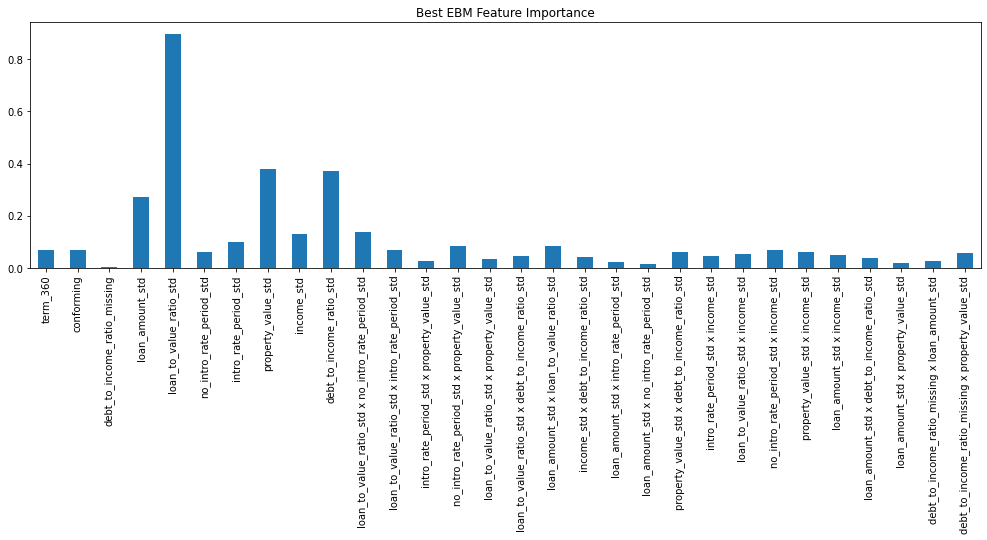

In [55]:
# init plot
fig, (ax2) = plt.subplots(ncols=1)
plt.tight_layout()
plt.subplots_adjust(left=0, right=2.2, wspace=0.2)

# plot global FI
_ = global_fi['EBM Importance'].plot(kind='bar',
                                     ax=ax2,
                                     title='Best EBM Feature Importance')

### Localized Importance

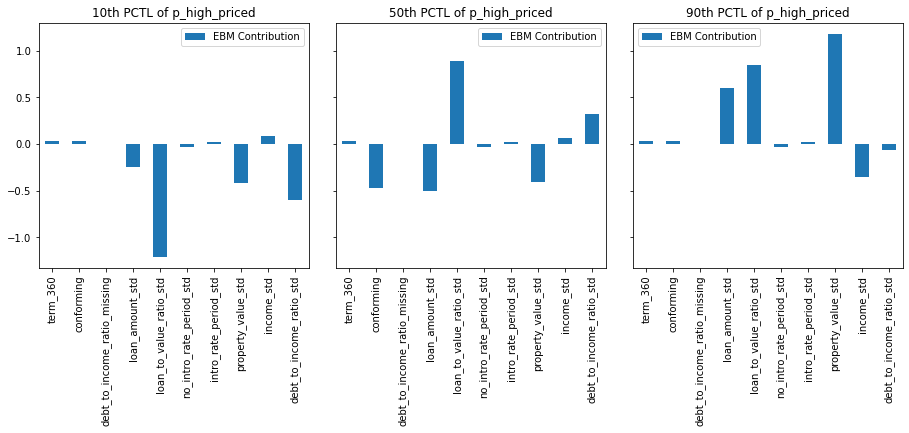

In [57]:
## init 3-pane plot
fig, (ax0, ax1, ax2) = plt.subplots(ncols=3, sharey=True)
plt.tight_layout()
plt.subplots_adjust(left=0, right=2, wspace=0.1)

# plot comparisons of local FI across 3 panes
_ = local_fi_dict[10].plot(kind='bar',
                           ax=ax0,
                           title='10th PCTL of p_high_priced')

_ = local_fi_dict[50].plot(kind='bar',
                           ax=ax1,
                           title='50th PCTL of p_high_priced')

_ = local_fi_dict[90].plot(kind='bar',
                           ax=ax2,
                           title='90th PCTL of p_high_priced')

### Partial Dependence: Utility Function

In [58]:
def par_dep(x_name, valid, model, model_type, resolution=20, bins=None):
    """ Creates Pandas DataFrame containing partial dependence or ICE
        for a single input variable.
        :param x_name: Variable for which to calculate partial dependence.
        :param valid: Pandas validation frame.
        :param model: Trained model object (assumes binary classifier).
        :param model_type: Kind of model: h2o, xgb, or ebm.
        :param resolution: The number of points across the domain of xs for which
                           to calculate partial dependence, default 20.
        :param bins: List of values at which to set xs, default 20 equally-spaced
                     points between column minimum and maximum.
        :return: Pandas DataFrame containing partial dependence values.
    """

    # turn off pesky Pandas copy warning
    pd.options.mode.chained_assignment = None

    # determine values at which to calculate partial dependence
    if bins is None:
        min_ = valid[x_name].min()
        max_ = valid[x_name].max()
        by = (max_ - min_) / resolution
        # modify max and by
        # to preserve resolution and actually search up to max
        bins = np.arange(min_, (max_ + by), (by + np.round(
            (1. / resolution) * by, 3)))

    # cache original column values
    col_cache = valid.loc[:, x_name].copy(deep=True)

    # calculate partial dependence
    # by setting column of interest to constant
    # and scoring the altered data and taking the mean of the predictions
    temp_df = valid.copy(deep=True)
    temp_df.loc[:, x_name] = bins[0]
    for j, _ in enumerate(bins):
        if j + 1 < len(bins):
            valid.loc[:, x_name] = bins[j + 1]
            temp_df = temp_df.append(valid, ignore_index=True)

    # return input frame to original cached state
    valid.loc[:, x_name] = col_cache

    # model predictions
    # probably assumes binary classification
    if model_type == 'h2o':
        temp_df['partial_dependence'] = model.predict(
            h2o.H2OFrame(temp_df))['p1'].as_data_frame()
    if model_type == 'xgb':
        temp_df['partial_dependence'] = pd.DataFrame(model.predict(
            xgb.DMatrix(temp_df),
            iteration_range=(0, best_mxgb.best_ntree_limit)),
                                                     columns=['phat'])
    if model_type == 'ebm':
        temp_df['partial_dependence'] = pd.DataFrame(
            model.predict_proba(temp_df)[:, 1], columns=['phat'])

    return pd.DataFrame(temp_df[[x_name, 'partial_dependence'
                                 ]].groupby([x_name]).mean()).reset_index()

In [66]:
#calculate partial dependence
# init dict to hold results
pd_dict = {}

# cycle through names and model types to calculate par dep
for name in x_names:

    print('Calculating partial dependence for %s ...' % name)

    # setup a dataframe to hold results
    # use bins from first par_dep() run
    pd_dict[name] = pd.DataFrame(columns=[name, 'ebm'])
    first_pd = par_dep(name, valid[x_names], best_ebm, 'ebm')
    pd_dict[name][name] = first_pd[name]
    bins = first_pd[name]

    # calculate par dep for ebm model
    pd_dict[name]['ebm'] = par_dep(name,
                                   valid[x_names],
                                   best_ebm,
                                   'ebm',
                                   bins=bins)['partial_dependence']

print('Done.')

Calculating partial dependence for term_360 ...
Calculating partial dependence for conforming ...
Calculating partial dependence for debt_to_income_ratio_missing ...
Calculating partial dependence for loan_amount_std ...
Calculating partial dependence for loan_to_value_ratio_std ...
Calculating partial dependence for no_intro_rate_period_std ...
Calculating partial dependence for intro_rate_period_std ...
Calculating partial dependence for property_value_std ...
Calculating partial dependence for income_std ...
Calculating partial dependence for debt_to_income_ratio_std ...
Done.


## Partial Dependence Plots

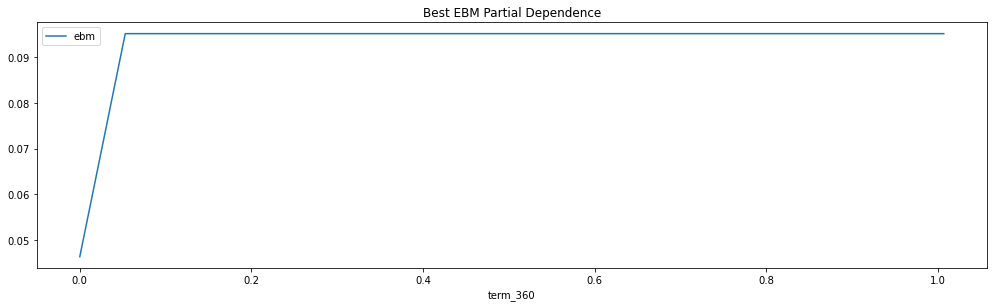

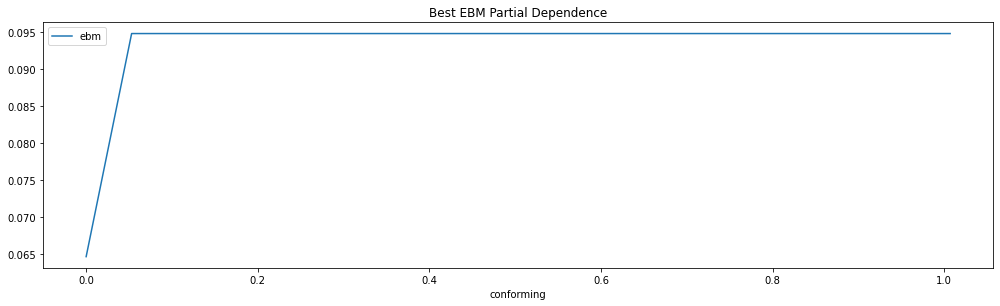

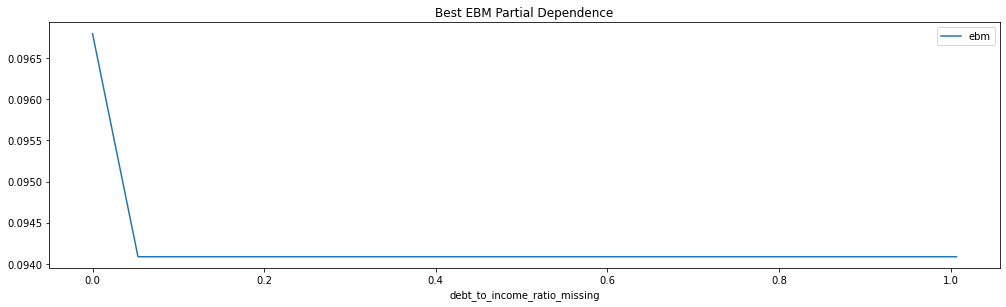

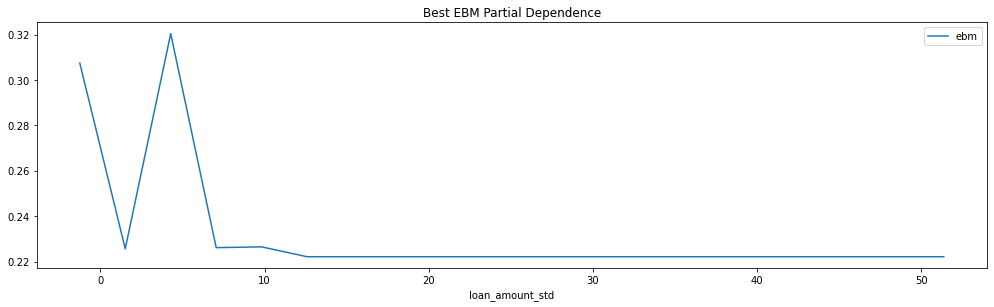

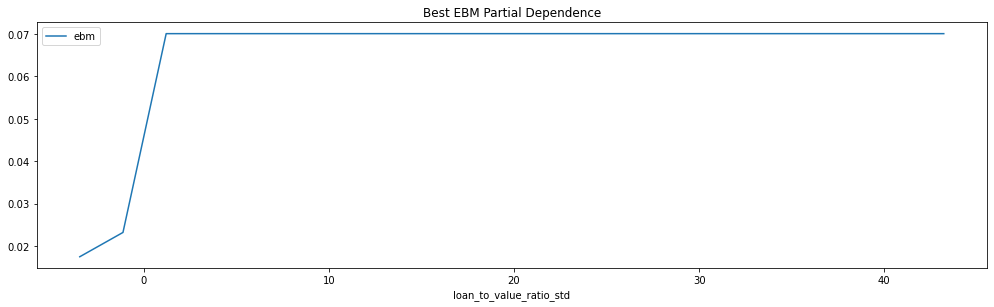

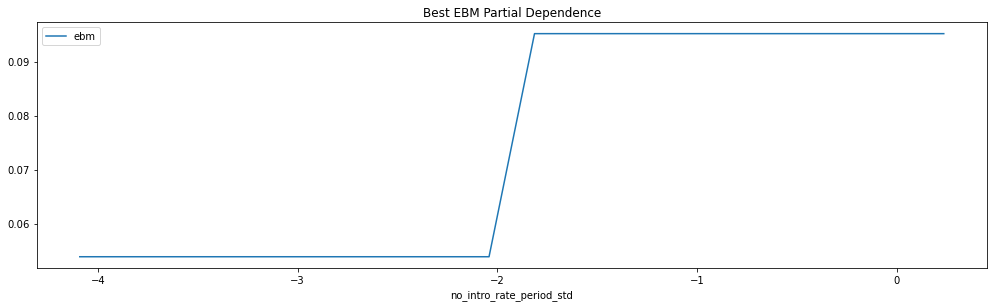

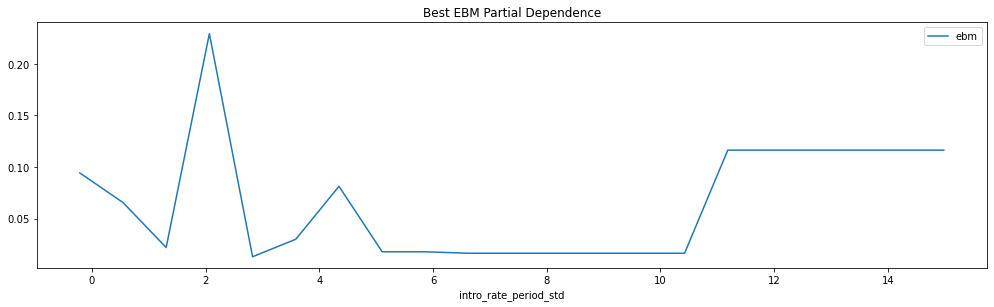

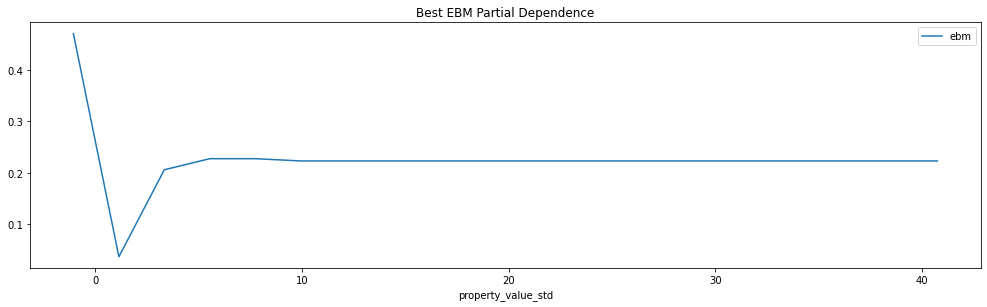

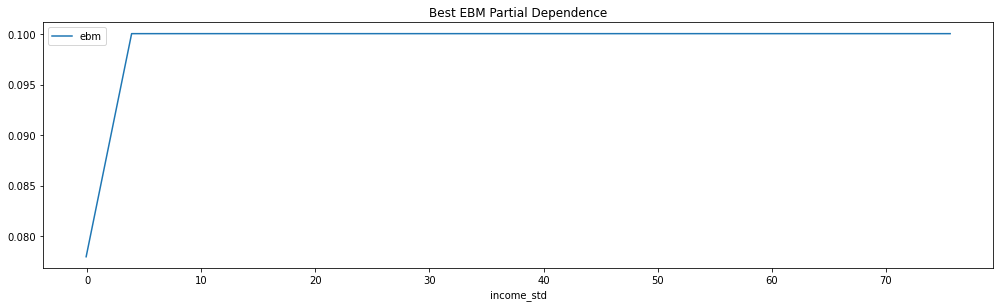

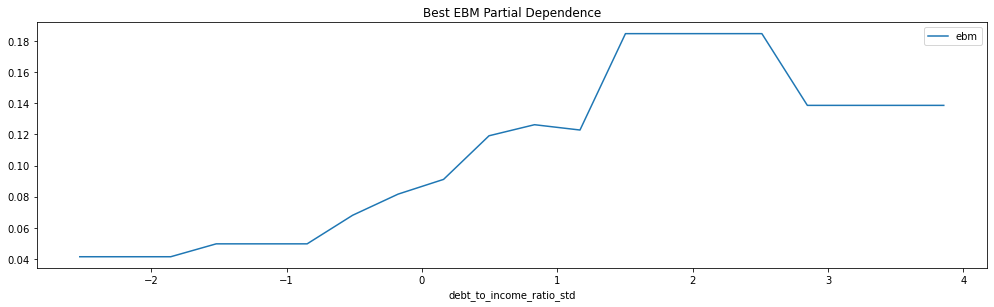

In [67]:
# loop through names to calculate par dep
for name in x_names:

    # init plot
    fig, (ax2) = plt.subplots(ncols=1, sharey=True)
    plt.tight_layout()
    plt.subplots_adjust(left=0, right=2.2, wspace=0.2)

    # plot par dep from model across frames
    pd_dict[name].plot(kind='line',
                       x=name,
                       y='ebm',
                       ax=ax2,
                       title='Best EBM Partial Dependence')
    ax2.set_xlabel(name)

In [68]:
#end h2o
h2o.cluster().shutdown(prompt=False)

H2O session _sid_aa9a closed.
